<a href="https://colab.research.google.com/github/koseoyoung/Informer2020/blob/main/Informer_with_pcap_multivariate.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Informer Demo

## Download code and dataset

In [1]:
!git clone https://github.com/koseoyoung/Informer2020.git
!git clone https://github.com/zhouhaoyi/ETDataset.git
!ls

fatal: destination path 'Informer2020' already exists and is not an empty directory.
fatal: destination path 'ETDataset' already exists and is not an empty directory.
ETDataset  Informer2020  sample_data


In [2]:
import sys
if not 'Informer2020' in sys.path:
    sys.path += ['Informer2020']

## Experiments: Train and Test (pcap)


In [3]:
from data.data_loader import Dataset_Custom
from torch.utils.data import DataLoader
import pandas as pd
import os
from utils.tools import dotdict
from exp.exp_informer import Exp_Informer
import torch

In [4]:
args = dotdict()

# custom data: xxx.csv
# data features: ['date', ...(other features), target feature]

args.model = 'informer' # model of experiment, options: [informer, informerstack, informerlight(TBD)]

args.data = 'custom' # data
args.root_path = './Informer2020/'
args.data_path = 'updated_pcap.csv'
args.features = 'M' # forecasting task, options:[M, S, MS]; M:multivariate predict multivariate, S:univariate predict univariate, MS:multivariate predict univariate
args.target = 'MUFL' # target feature in S or MS task
args.freq = 'h' # freq for time features encoding, options:[s:secondly, t:minutely, h:hourly, d:daily, b:business days, w:weekly, m:monthly], you can also use more detailed freq like 15min or 3h
args.checkpoints = './informer_checkpoints' # location of model checkpoints

args.seq_len = 96 # input sequence length of Informer encoder
args.label_len = 48 # start token length of Informer decoder
args.pred_len = 24 # prediction sequence length
# Informer decoder input: concat[start token series(label_len), zero padding series(pred_len)]

args.enc_in = 7 # encoder input size
args.dec_in = 7 # decoder input size
args.c_out = 7 # output size
args.factor = 5 # probsparse attn factor
args.d_model = 512 # dimension of model
args.n_heads = 8 # num of heads
args.e_layers = 2 # num of encoder layers
args.d_layers = 1 # num of decoder layers
args.d_ff = 2048 # dimension of fcn in model
args.dropout = 0.05 # dropout
args.attn = 'prob' # attention used in encoder, options:[prob, full]
args.embed = 'timeF' # time features encoding, options:[timeF, fixed, learned]
args.activation = 'gelu' # activation
args.distil = True # whether to use distilling in encoder
args.output_attention = False # whether to output attention in ecoder
args.mix = True
args.padding = 0
args.freq = 'h'

args.batch_size = 32 
args.learning_rate = 0.0001
args.loss = 'mse'
args.lradj = 'type1'
args.use_amp = False # whether to use automatic mixed precision training

args.num_workers = 0
args.itr = 1
args.train_epochs = 6
args.patience = 3
args.des = 'exp'

args.use_gpu = True if torch.cuda.is_available() else False
args.gpu = 0

args.use_multi_gpu = False
args.devices = '0,1,2,3'


In [5]:
df = pd.read_csv(os.path.join(args.root_path, args.data_path))
df.head(20)

,date,dstip,srcport,dstport,srcip,pkt_len,tos,id,flag,ttl,chksum
0,2015-05-21 13:01:00,3617517303,443,37587,3692851740,1450,0,44751,2,87,23215
1,2015-05-21 13:01:00,1345729051,46878,80,109911137,52,0,14771,2,53,26322
2,2015-05-21 13:01:00,2243093303,443,41194,3692851740,1450,0,37555,2,87,54391
3,2015-05-21 13:01:00,1554569608,54880,80,2010882219,52,0,61996,2,53,1248
4,2015-05-21 13:01:00,105510777,80,35462,3617471187,1500,8,19777,2,60,56222
5,2015-05-21 13:01:00,1345729051,46878,80,109911137,52,0,14772,2,53,26321
6,2015-05-21 13:01:00,3617517303,443,37587,3692851740,1450,0,44752,2,87,23214
7,2015-05-21 13:01:00,2243093086,80,58531,1692443503,1500,0,21984,2,59,29659
8,2015-05-21 13:01:00,2243093303,443,41194,3692851740,1450,0,37556,2,87,54390
9,2015-05-21 13:01:00,105510777,80,35462,3617471187,1500,8,19778,2,60,56221


In [6]:
'''
We set 'HULL' as target instead of 'OT'

The following frequencies are supported:
        Y   - yearly
            alias: A
        M   - monthly
        W   - weekly
        D   - daily
        B   - business days
        H   - hourly
        T   - minutely
            alias: min
        S   - secondly
'''

args.target = 'pkt_len'
args.freq = 's'
args.data = "custom"

args.seq_len = 96 # input sequence length of Informer encoder
args.label_len = 48 # start token length of Informer decoder
args.pred_len = 24 # prediction sequence length
# Informer decoder input: concat[start token series(label_len), zero padding series(pred_len)]

args.enc_in = 10 # encoder input size
args.dec_in = 10 # decoder input size
args.c_out = 10 # output size
args.factor = 5 # probsparse attn factor
args.d_model = 512 # dimension of model
args.n_heads = 11 # num of heads
args.e_layers = 2 # num of encoder layers
args.d_layers = 1 # num of decoder layers
args.d_ff = 2048 # dimension of fcn in model
args.dropout = 0.05 # dropout
args.attn = 'prob' # attention used in encoder, options:[prob, full]
args.embed = 'timeF' # time features encoding, options:[timeF, fixed, learned]
args.activation = 'gelu' # activation
args.distil = True # whether to use distilling in encoder
args.output_attention = False # whether to output attention in ecoder
args.mix = True
args.padding = 0

args.batch_size = 32 
args.learning_rate = 0.0001
args.loss = 'mse'
args.lradj = 'type1'
args.use_amp = False # whether to use automatic mixed precision training

args.num_workers = 0
args.itr = 1
args.train_epochs = 6
args.patience = 3
args.des = 'exp'
args.features = 'M'

Data = Dataset_Custom
timeenc = 0 if args.embed!='timeF' else 1
flag = 'test'; shuffle_flag = False; drop_last = True; batch_size = 1

data_set = Data(
    root_path=args.root_path,
    data_path=args.data_path,
    flag=flag,
    size=[args.seq_len, args.label_len, args.pred_len],
    features=args.features,
    timeenc=timeenc,
    target=args.target, # HULL here
    freq=args.freq # 'h': hourly, 't':minutely
)
data_loader = DataLoader(
    data_set,
    batch_size=batch_size,
    shuffle=shuffle_flag,
    num_workers=args.num_workers,
    drop_last=drop_last)

In [7]:
batch_x,batch_y,batch_x_mark,batch_y_mark = data_set[0]
print (batch_x.shape)
print (batch_y.shape)
print (batch_x_mark.shape)

(96, 10)
(72, 10)
(96, 6)


In [8]:
args.detail_freq = args.freq
args.freq = args.freq[-1:]

In [9]:
print(args)

{'model': 'informer', 'data': 'custom', 'root_path': './Informer2020/', 'data_path': 'updated_pcap.csv', 'features': 'M', 'target': 'pkt_len', 'freq': 's', 'checkpoints': './informer_checkpoints', 'seq_len': 96, 'label_len': 48, 'pred_len': 24, 'enc_in': 10, 'dec_in': 10, 'c_out': 10, 'factor': 5, 'd_model': 512, 'n_heads': 11, 'e_layers': 2, 'd_layers': 1, 'd_ff': 2048, 'dropout': 0.05, 'attn': 'prob', 'embed': 'timeF', 'activation': 'gelu', 'distil': True, 'output_attention': False, 'mix': True, 'padding': 0, 'batch_size': 32, 'learning_rate': 0.0001, 'loss': 'mse', 'lradj': 'type1', 'use_amp': False, 'num_workers': 0, 'itr': 1, 'train_epochs': 6, 'patience': 3, 'des': 'exp', 'use_gpu': True, 'gpu': 0, 'use_multi_gpu': False, 'devices': '0,1,2,3', 'detail_freq': 's'}


In [10]:
Exp = Exp_Informer

In [11]:
for ii in range(args.itr):
    # setting record of experiments
    setting = '{}_{}_ft{}_sl{}_ll{}_pl{}_dm{}_nh{}_el{}_dl{}_df{}_at{}_fc{}_eb{}_dt{}_mx{}_{}_{}'.format(args.model, args.data, args.features, 
                args.seq_len, args.label_len, args.pred_len,
                args.d_model, args.n_heads, args.e_layers, args.d_layers, args.d_ff, args.attn, args.factor, args.embed, args.distil, args.mix, args.des, ii)

    # set experiments
    exp = Exp(args)
    
    # train
    print('>>>>>>>start training : {}>>>>>>>>>>>>>>>>>>>>>>>>>>'.format(setting))
    exp.train(setting)
    
    # test
    print('>>>>>>>testing : {}<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<'.format(setting))
    exp.test(setting)

    torch.cuda.empty_cache()

Use GPU: cuda:0
>>>>>>>start training : informer_custom_ftM_sl96_ll48_pl24_dm512_nh11_el2_dl1_df2048_atprob_fc5_ebtimeF_dtTrue_mxTrue_exp_0>>>>>>>>>>>>>>>>>>>>>>>>>>
train 9848
val 1402
test 2824
	iters: 100, epoch: 1 | loss: 0.9164338
	speed: 0.1658s/iter; left time: 289.0360s
	iters: 200, epoch: 1 | loss: 1.2673559
	speed: 0.0799s/iter; left time: 131.2130s
	iters: 300, epoch: 1 | loss: 1.0498335
	speed: 0.0910s/iter; left time: 140.3466s
Epoch: 1 cost time: 34.23435831069946
Epoch: 1, Steps: 307 | Train Loss: 0.9761229 Vali Loss: 0.9937961 Test Loss: 1.1528388
Validation loss decreased (inf --> 0.993796).  Saving model ...
Updating learning rate to 0.0001
	iters: 100, epoch: 2 | loss: 0.8453141
	speed: 0.1183s/iter; left time: 169.8962s
	iters: 200, epoch: 2 | loss: 0.8629963
	speed: 0.0769s/iter; left time: 102.7667s
	iters: 300, epoch: 2 | loss: 0.8476310
	speed: 0.0773s/iter; left time: 95.5003s
Epoch: 2 cost time: 23.61851477622986
Epoch: 2, Steps: 307 | Train Loss: 0.9012206 Va

## Predict (pcap) 

In [12]:
import os

# set saved model path
setting = 'informer_custom_ftM_sl96_ll48_pl24_dm512_nh11_el2_dl1_df2048_atprob_fc5_ebtimeF_dtTrue_mxTrue_exp_0'

# path = os.path.join(args.checkpoints,setting,'checkpoint.pth')

In [13]:
# If you already have a trained model, you can set the arguments and model path, then initialize a Experiment and use it to predict
# Prediction is a sequence which is adjacent to the last date of the data, and does not exist in the data
# If you want to get more information about prediction, you can refer to code `exp/exp_informer.py function predict()` and `data/data_loader.py class Dataset_Pred`
exp = Exp(args)
exp.predict(setting, True)

Use GPU: cuda:0
pred 1


In [14]:
# the prediction will be saved in ./results/{setting}/real_prediction.npy
import numpy as np

prediction = np.load('./results/'+setting+'/real_prediction.npy')

prediction.shape

(1, 24, 10)

### More details about Prediction - prediction function

In [15]:
# here is the detailed code of function predict

def predict(exp, setting, load=False):
    pred_data, pred_loader = exp._get_data(flag='pred')
        
    if load:
        path = os.path.join(exp.args.checkpoints, setting)
        best_model_path = path+'/'+'checkpoint.pth'
        exp.model.load_state_dict(torch.load(best_model_path))

    exp.model.eval()
        
    preds = []
        
    for i, (batch_x,batch_y,batch_x_mark,batch_y_mark) in enumerate(pred_loader):
        batch_x = batch_x.float().to(exp.device)
        batch_y = batch_y.float()
        batch_x_mark = batch_x_mark.float().to(exp.device)
        batch_y_mark = batch_y_mark.float().to(exp.device)

        # decoder input
        if exp.args.padding==0:
            dec_inp = torch.zeros([batch_y.shape[0], exp.args.pred_len, batch_y.shape[-1]]).float()
        elif exp.args.padding==1:
            dec_inp = torch.ones([batch_y.shape[0], exp.args.pred_len, batch_y.shape[-1]]).float()
        else:
            dec_inp = torch.zeros([batch_y.shape[0], exp.args.pred_len, batch_y.shape[-1]]).float()
        dec_inp = torch.cat([batch_y[:,:exp.args.label_len,:], dec_inp], dim=1).float().to(exp.device)
        # encoder - decoder
        if exp.args.use_amp:
            with torch.cuda.amp.autocast():
                if exp.args.output_attention:
                    outputs = exp.model(batch_x, batch_x_mark, dec_inp, batch_y_mark)[0]
                else:
                    outputs = exp.model(batch_x, batch_x_mark, dec_inp, batch_y_mark)
        else:
            if exp.args.output_attention:
                outputs = exp.model(batch_x, batch_x_mark, dec_inp, batch_y_mark)[0]
            else:
                outputs = exp.model(batch_x, batch_x_mark, dec_inp, batch_y_mark)
        f_dim = -1 if exp.args.features=='MS' else 0
        batch_y = batch_y[:,-exp.args.pred_len:,f_dim:].to(exp.device)
        
        pred = outputs.detach().cpu().numpy()#.squeeze()
        
        preds.append(pred)

    preds = np.array(preds)
    preds = preds.reshape(-1, preds.shape[-2], preds.shape[-1])
    
    # result save
    folder_path = './results/' + setting +'/'
    if not os.path.exists(folder_path):
        os.makedirs(folder_path)
    
    np.save(folder_path+'real_prediction.npy', preds)
    
    return preds


In [16]:
# you can also use this prediction function to get result
prediction = predict(exp, setting, True)

pred 1


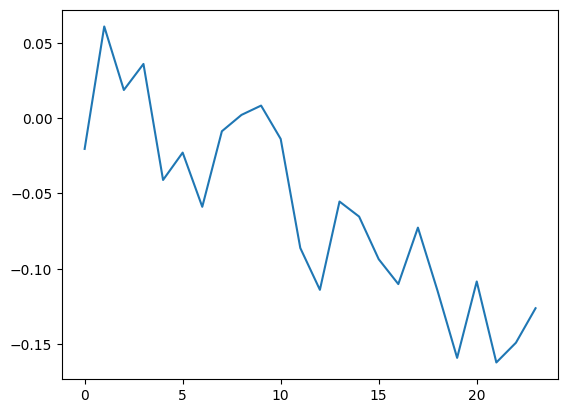

In [17]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot(prediction[0,:,-1])
plt.show()

### More details about Prediction - prediction dataset

You can give a `root_path` and `data_path` of the data you want to forecast, and set `seq_len`, `label_len`, `pred_len` and other arguments as other Dataset. The difference is that you can set a more detailed freq such as `15min` or `3h` to generate the timestamp of prediction series.

`Dataset_Pred` only has one sample (including `encoder_input: [1, seq_len, dim]`, `decoder_token: [1, label_len, dim]`, `encoder_input_timestamp: [1, seq_len, date_dim]`, `decoder_input_timstamp: [1, label_len+pred_len, date_dim]`). It will intercept the last sequence of the given data (seq_len data) to forecast the unseen future sequence (pred_len data).

In [18]:
from data.data_loader import Dataset_Pred
from torch.utils.data import DataLoader

In [19]:
Data = Dataset_Pred
timeenc = 0 if args.embed!='timeF' else 1
flag = 'pred'; shuffle_flag = False; drop_last = False; batch_size = 1

freq = 's'
print(freq)

data_set = Data(
    root_path=args.root_path,
    data_path=args.data_path,
    flag=flag,
    size=[args.seq_len, args.label_len, args.pred_len],
    features=args.features,
    target=args.target,
    timeenc=timeenc,
    freq=freq
)
data_loader = DataLoader(
    data_set,
    batch_size=batch_size,
    shuffle=shuffle_flag,
    num_workers=args.num_workers,
    drop_last=drop_last)

s


In [20]:
len(data_set), len(data_loader)

(1, 1)

## Visualization (pcap)

In [21]:
# When we finished exp.train(setting) and exp.test(setting), we will get a trained model and the results of test experiment
# The results of test experiment will be saved in ./results/{setting}/pred.npy (prediction of test dataset) and ./results/{setting}/true.npy (groundtruth of test dataset)

preds = np.load('./results/'+setting+'/pred.npy')
trues = np.load('./results/'+setting+'/true.npy')

# [samples, pred_len, dimensions]
preds.shape, trues.shape

((2816, 24, 10), (2816, 24, 10))

In [22]:
import matplotlib.pyplot as plt
import seaborn as sns

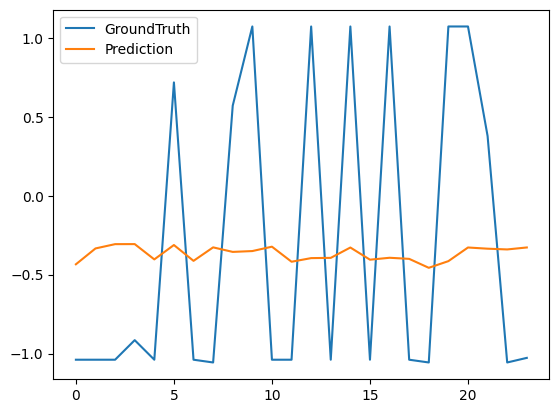

In [23]:
# draw checksum prediction
plt.figure()
plt.plot(trues[0,:,-1], label='GroundTruth')
plt.plot(preds[0,:,-1], label='Prediction')
plt.legend()
plt.show()

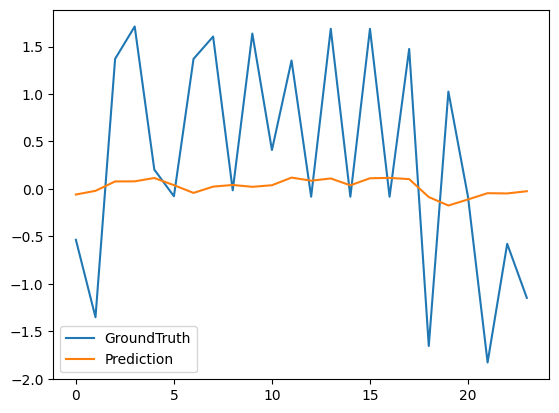

In [24]:
# draw ttl prediction
plt.figure()
plt.plot(trues[0,:,-2], label='GroundTruth')
plt.plot(preds[0,:,-2], label='Prediction')
plt.legend()
plt.show()

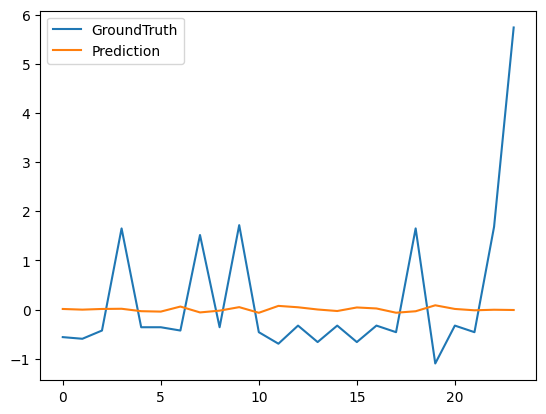

In [25]:
# draw ttl prediction
plt.figure()
plt.plot(trues[0,:,-3], label='GroundTruth')
plt.plot(preds[0,:,-3], label='Prediction')
plt.legend()
plt.show()

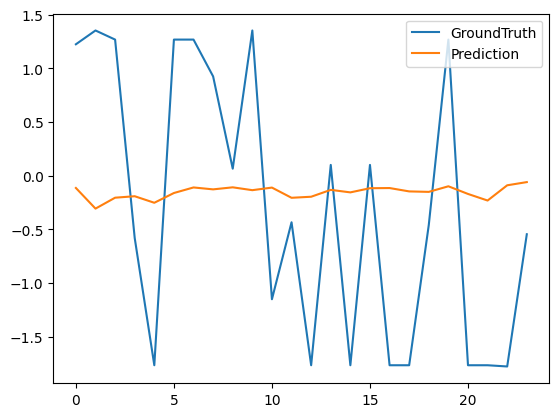

In [26]:
# draw dstip prediction
plt.figure()
plt.plot(trues[0,:,0], label='GroundTruth')
plt.plot(preds[0,:,0], label='Prediction')
plt.legend()
plt.show()

In [27]:
from data.data_loader import Dataset_ETT_hour
from torch.utils.data import DataLoader

Data = Dataset_ETT_hour
timeenc = 0 if args.embed!='timeF' else 1
flag = 'test'; shuffle_flag = False; drop_last = True; batch_size = 1

data_set = Data(
    root_path=args.root_path,
    data_path=args.data_path,
    flag=flag,
    size=[args.seq_len, args.label_len, args.pred_len],
    features=args.features,
    timeenc=timeenc,
    freq=args.freq
)
data_loader = DataLoader(
    data_set,
    batch_size=batch_size,
    shuffle=shuffle_flag,
    num_workers=args.num_workers,
    drop_last=drop_last)

In [28]:
import os

args.output_attention = True

exp = Exp(args)

model = exp.model

setting = 'informer_custom_ftM_sl96_ll48_pl24_dm512_nh11_el2_dl1_df2048_atprob_fc5_ebtimeF_dtTrue_mxTrue_exp_0'
path = os.path.join(args.checkpoints,setting,'checkpoint.pth')
model.load_state_dict(torch.load(path))

Use GPU: cuda:0


<All keys matched successfully>

In [29]:
# attention visualization
idx = 0
for i, (batch_x,batch_y,batch_x_mark,batch_y_mark) in enumerate(data_loader):
    if i!=idx:
        continue
    batch_x = batch_x.float().to(exp.device)
    batch_y = batch_y.float()

    batch_x_mark = batch_x_mark.float().to(exp.device)
    batch_y_mark = batch_y_mark.float().to(exp.device)
    
    dec_inp = torch.zeros_like(batch_y[:,-args.pred_len:,:]).float()
    dec_inp = torch.cat([batch_y[:,:args.label_len,:], dec_inp], dim=1).float().to(exp.device)
    
    outputs,attn = model(batch_x, batch_x_mark, dec_inp, batch_y_mark)

In [30]:
attn[0].shape, attn[1].shape #, attn[2].shape

(torch.Size([1, 11, 96, 96]), torch.Size([1, 11, 48, 48]))

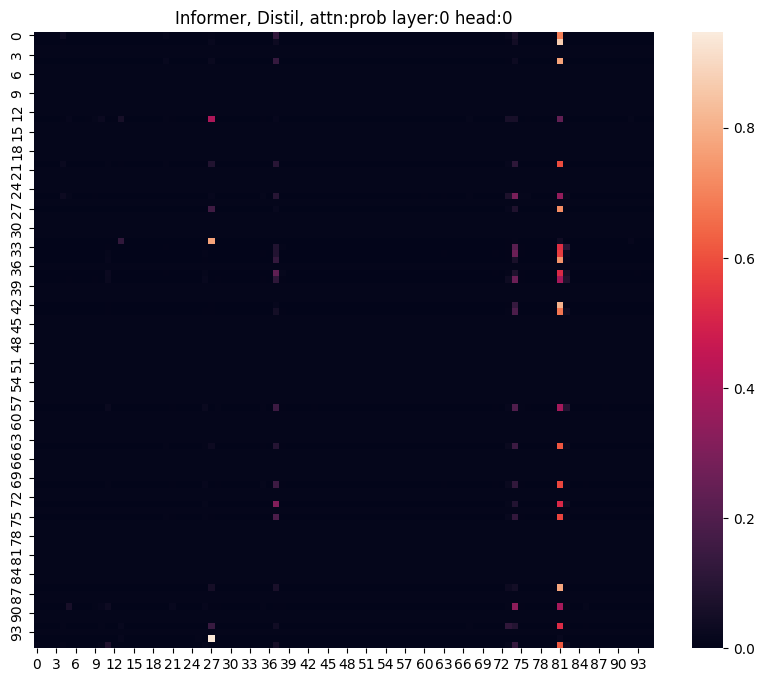

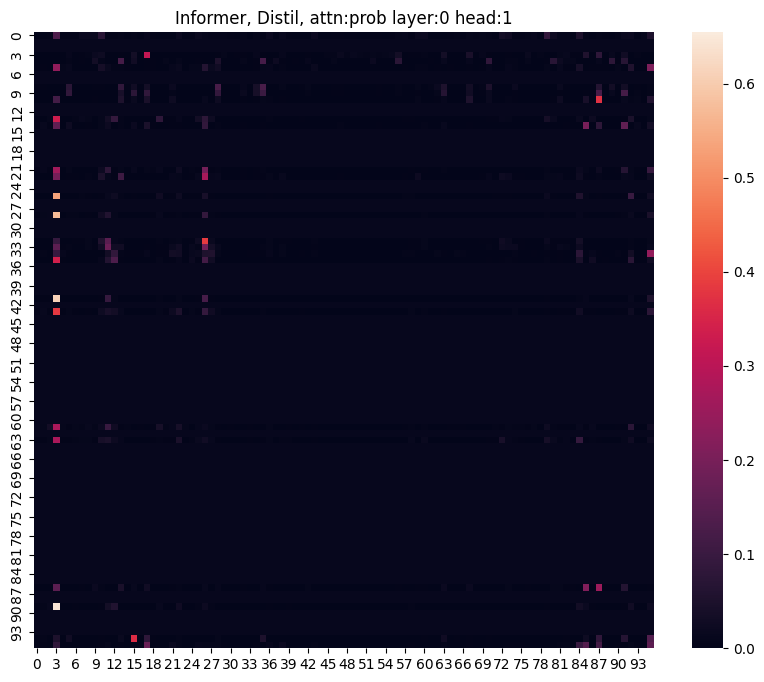

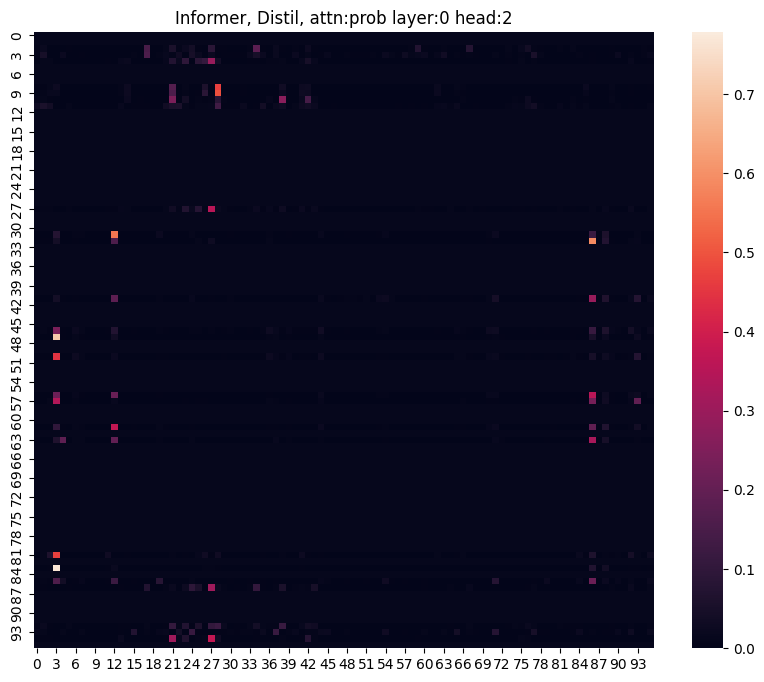

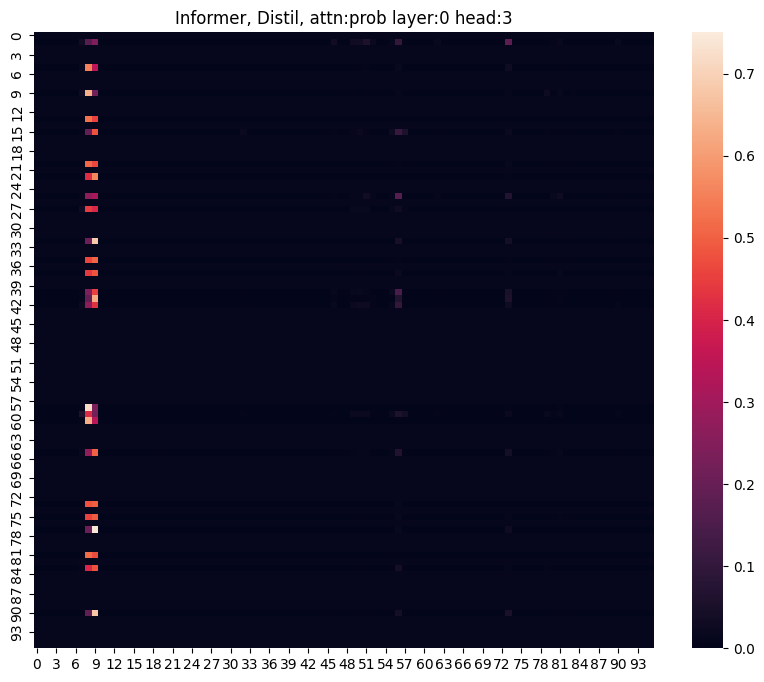

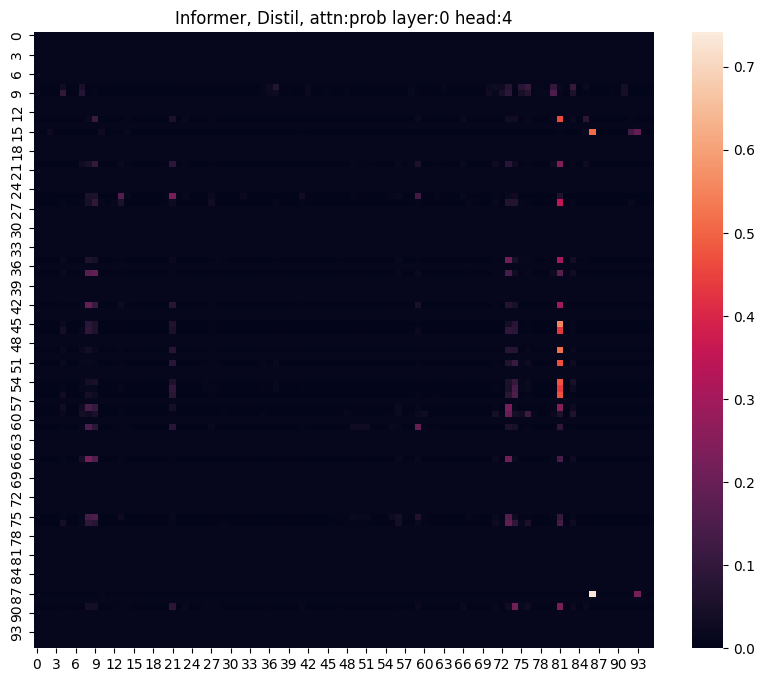

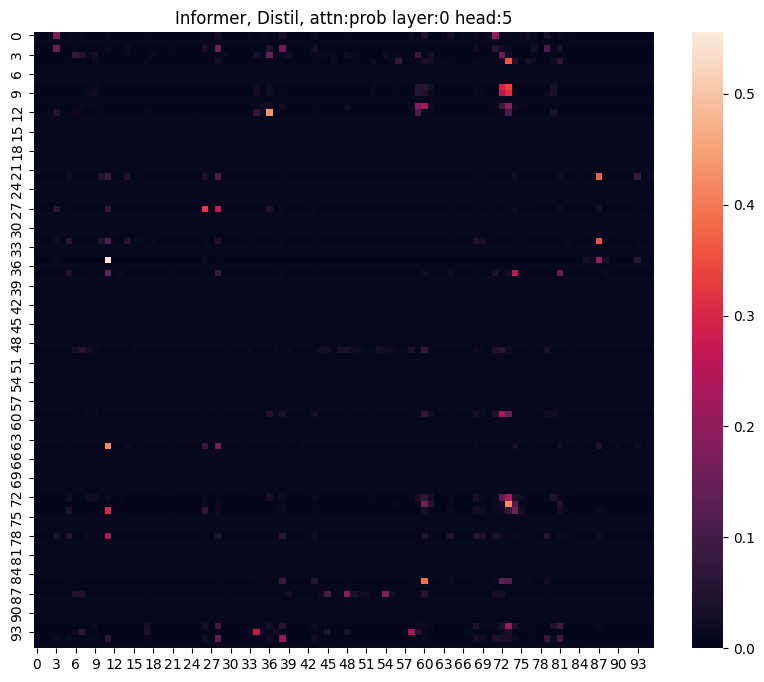

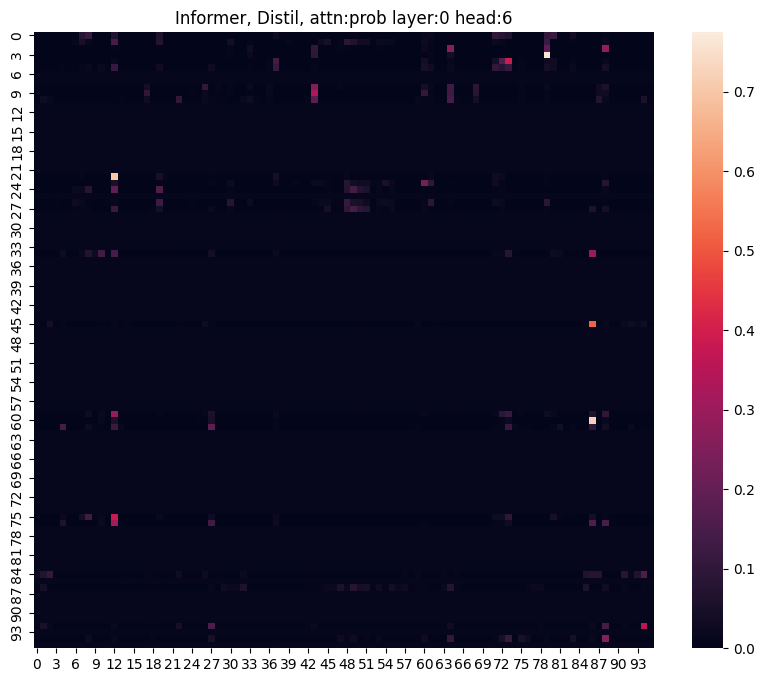

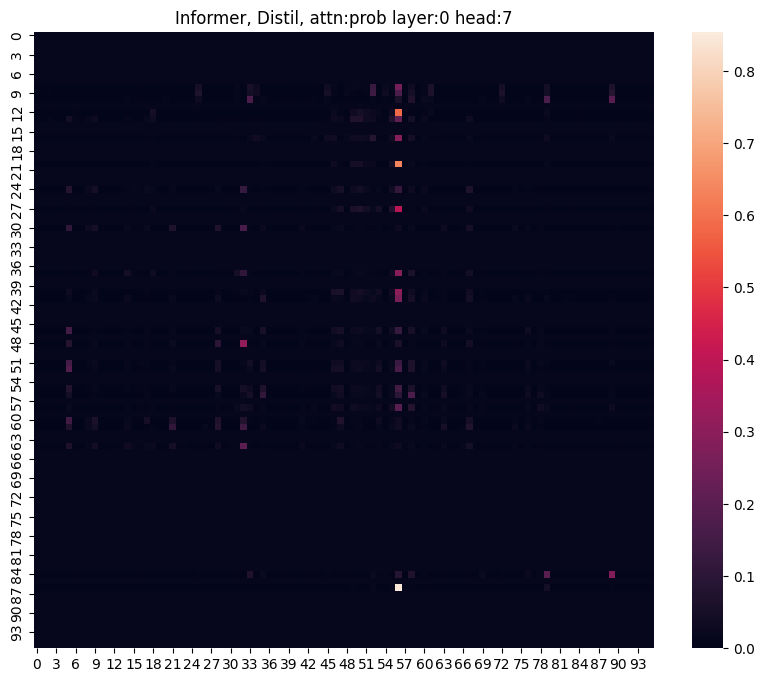

In [31]:
layer = 0
distil = 'Distil' if args.distil else 'NoDistil'
for h in range(0,8):
    plt.figure(figsize=[10,8])
    plt.title('Informer, {}, attn:{} layer:{} head:{}'.format(distil, args.attn, layer, h))
    A = attn[layer][0,h].detach().cpu().numpy()
    ax = sns.heatmap(A, vmin=0, vmax=A.max()+0.01)
    plt.show()

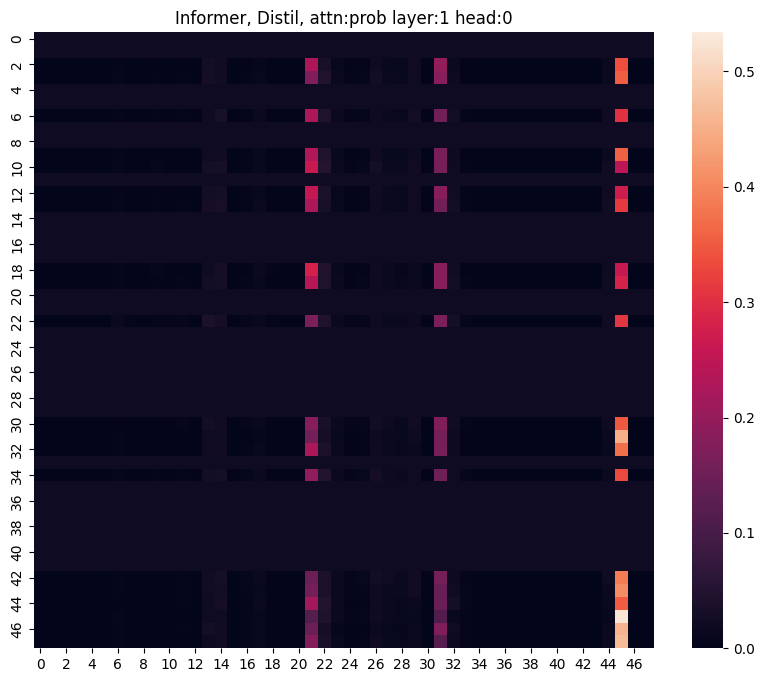

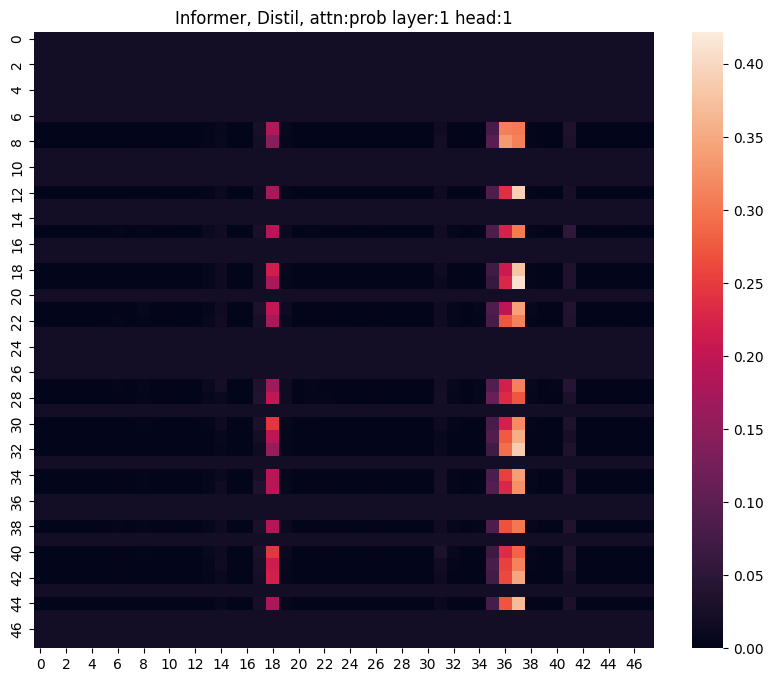

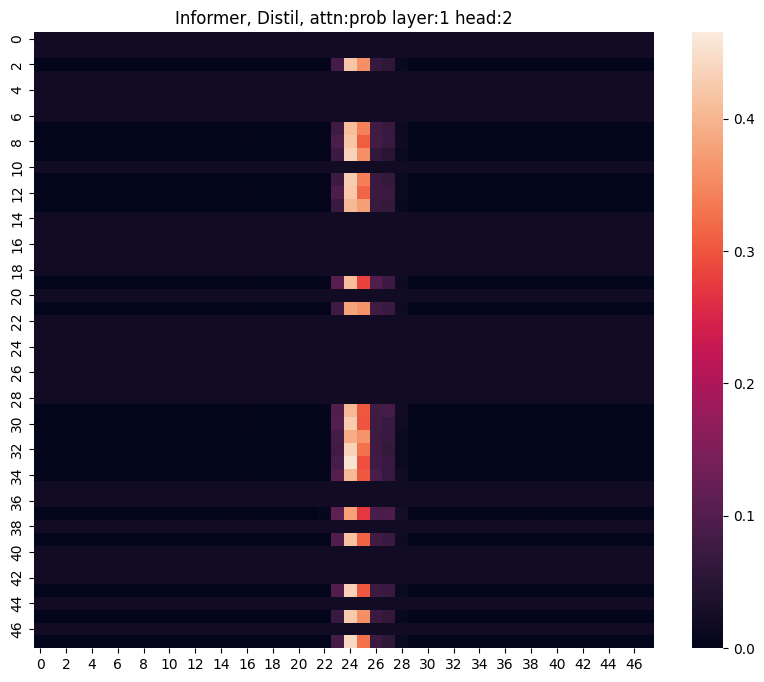

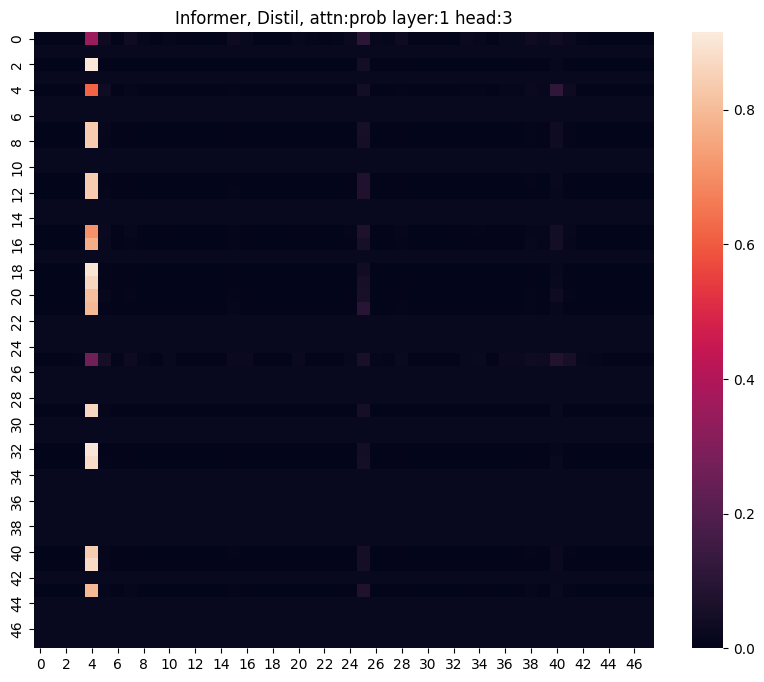

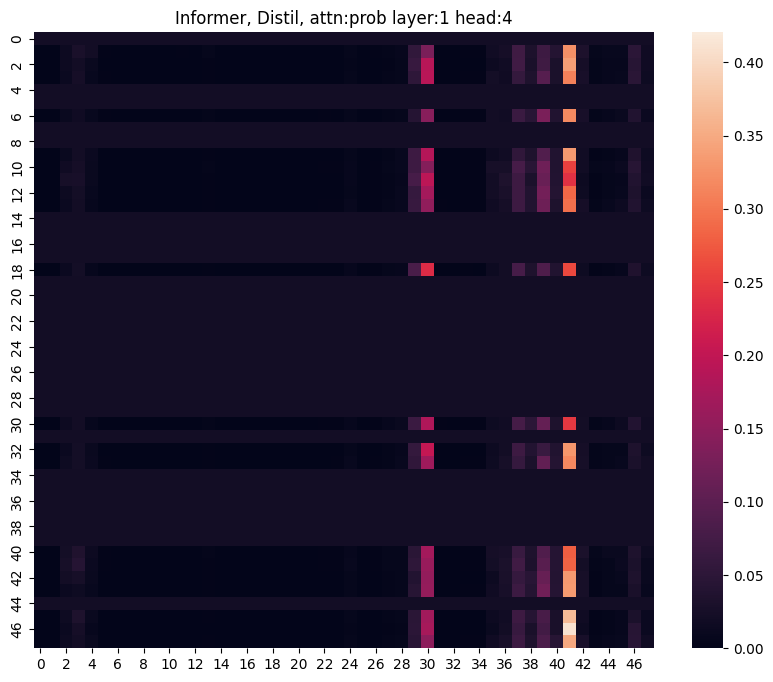

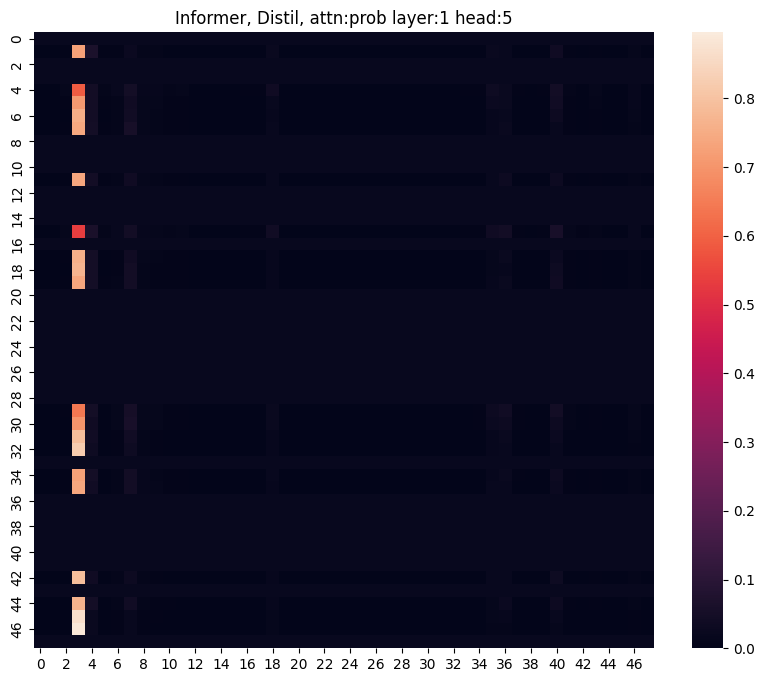

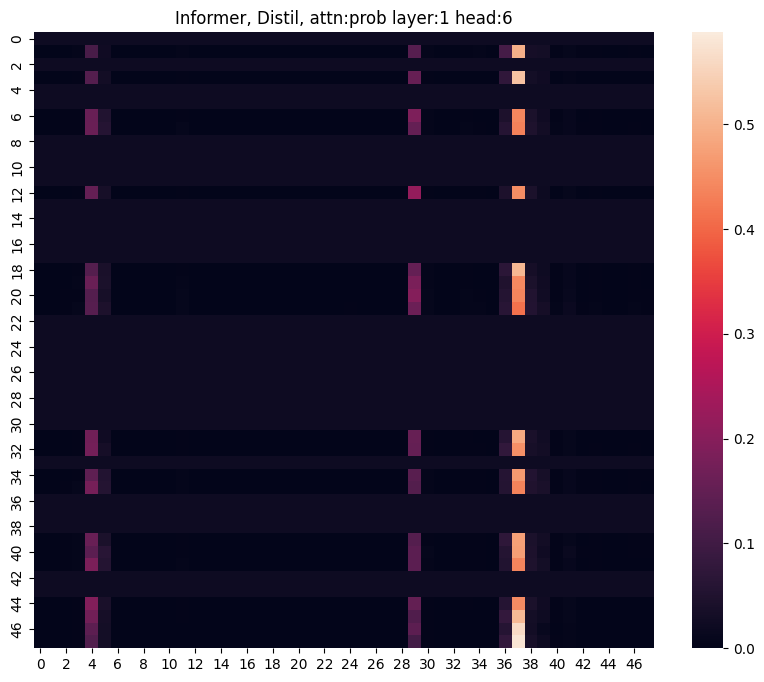

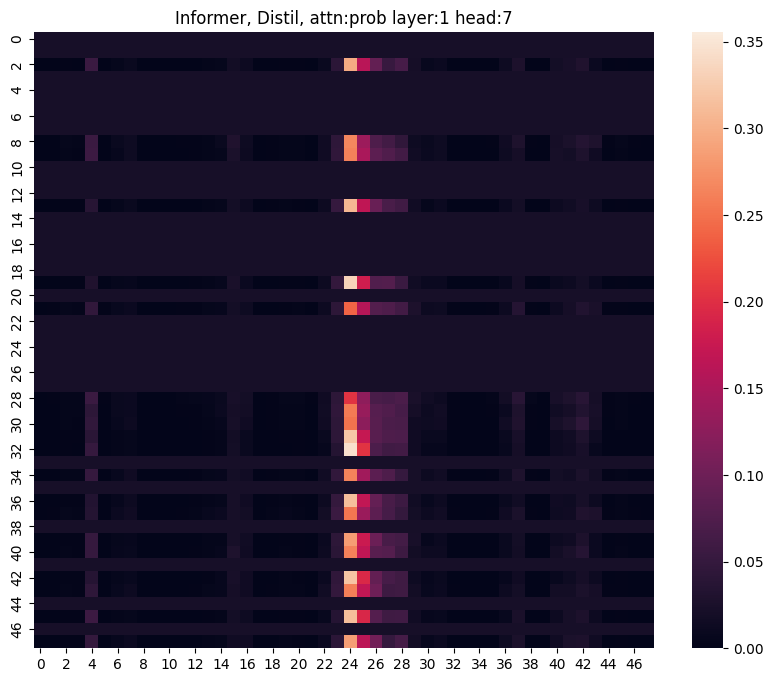

In [32]:
layer = 1
distil = 'Distil' if args.distil else 'NoDistil'
for h in range(0,8):
    plt.figure(figsize=[10,8])
    plt.title('Informer, {}, attn:{} layer:{} head:{}'.format(distil, args.attn, layer, h))
    A = attn[layer][0,h].detach().cpu().numpy()
    ax = sns.heatmap(A, vmin=0, vmax=A.max()+0.01)
    plt.show()